In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
df = pd.read_csv('./data/soratena_tonga.csv',parse_dates=["DATE(UTC)"])
df.head()

,SoratenaID,DATE(UTC),ARPRSS,SoratenaName,LATD,LOND
0,1001,2022-01-15 11:00:00,997.7,鶴居タンチョウパパ,43.226,144.309
1,1001,2022-01-15 11:01:00,997.7,鶴居タンチョウパパ,43.226,144.309
2,1001,2022-01-15 11:02:00,997.8,鶴居タンチョウパパ,43.226,144.309
3,1001,2022-01-15 11:03:00,997.8,鶴居タンチョウパパ,43.226,144.309
4,1001,2022-01-15 11:04:00,997.9,鶴居タンチョウパパ,43.226,144.309


In [3]:
df.describe()

,SoratenaID,ARPRSS,LATD,LOND
count,764935.000000,764935.000000,764935.000000,764935.000000
mean,21404.936413,1000.603509,35.887148,136.873705
std,13172.020942,27.311418,2.783114,3.646831
min,1001.000000,828.700000,24.330000,123.819000
25%,11073.000000,995.400000,34.435000,134.238000
50%,21056.000000,1010.500000,35.383000,137.189000
75%,32014.000000,1016.700000,36.539000,139.798000
max,47039.000000,1032.500000,45.448000,145.582000


In [4]:
df.shape

(764935, 6)

In [5]:
df["SoratenaID"].unique().shape

(1583,)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764935 entries, 0 to 764934
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SoratenaID    764935 non-null  int64         
 1   DATE(UTC)     764935 non-null  datetime64[ns]
 2   ARPRSS        764935 non-null  float64       
 3   SoratenaName  764935 non-null  object        
 4   LATD          764935 non-null  float64       
 5   LOND          764935 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 35.0+ MB


In [7]:
dfgByID = df.groupby(by=['SoratenaID'])

In [8]:
#get unqiue ids of antennas
ids = df["SoratenaID"].unique()

In [94]:
#create a range of dates from the data
# x = pd.date_range(start=df['DATE(UTC)'].min(),end=df['DATE(UTC)'].max(),freq='60s',)
x = pd.date_range(start='2022-01-15 11:00:00',end='2022-01-16 00:00:00',freq='60s',)
#get data and plot until maximum
#create a df with ids,dates,max air pressure
maxap = pd.DataFrame()
maxap['id'] = ids
dates = []
maxv = []
for id in ids:
    temp = dfgByID.get_group(id)
    y = temp[temp['DATE(UTC)'].isin(x)]
    max_value = y['ARPRSS'].max()
    pos_max = y['ARPRSS'].idxmax()
    date_max = y['DATE(UTC)'][pos_max]
    dates.append(date_max)
    maxv.append(max_value)
    # ax = y.plot(x='DATE(UTC)',y='ARPRSS',color='k')
    # ax.axvline(date_max,ls='--',color='red')
maxap['date']=dates
maxap['value']=maxv

In [97]:
maxap.to_csv('./data/soratena_max_value.csv')

<AxesSubplot:>

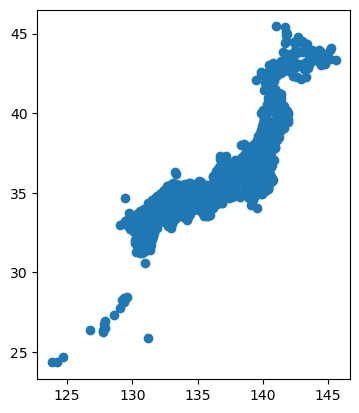

In [10]:
import geopandas as gpd
#convert to geopandas
df_rd = df.drop_duplicates(subset=['LATD','LOND'])
gdf = gpd.GeoDataFrame(df_rd,geometry=gpd.points_from_xy(df_rd['LOND'],df_rd['LATD']),crs='EPSG:4326')
gdf.plot()

In [11]:
gdf.shape

(1583, 7)

<AxesSubplot:>

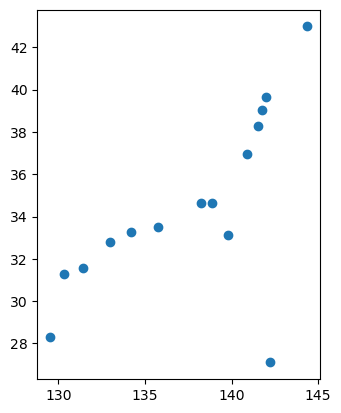

In [12]:
st = pd.read_csv('./data/Station_withTTT.csv',usecols=[0,1,2,3])
gst = gpd.GeoDataFrame(st,geometry=gpd.points_from_xy(st.Longitude,st.Latitude),crs='EPSG:4326')
gst.plot()

In [13]:
#change all to planar system (geopandas need planar to do distance analysis)

gdf.to_crs('EPSG:3095',inplace=True) #'EPSG:3095' Tokyo / UTM zone 54N
gst.to_crs('EPSG:3095',inplace=True)

In [87]:
#join points of soratena (gdf) and find the closer ones to tide stations (gst)
apst = gst.sjoin_nearest(gdf,how='inner',distance_col='dist')

In [88]:
#drop same points
apst.drop_duplicates(subset=['dist'],inplace=True)

In [89]:
gst.shape,apst.shape

((15, 5), (15, 13))

In [90]:
apst.head()

,Station,Latitude,Longitude,minutes,geometry,index_right,SoratenaID,DATE(UTC),ARPRSS,SoratenaName,LATD,LOND,dist
0,Kushiro,42.983,144.367,648.1,POINT (774830.730 4763680.564),8230,1041,2022-01-15 11:00:00,1012.9,釧路こんぶばぁば,43.003,144.423,5081.434842
1,Miyako,39.650,141.983,640.2,POINT (584638.929 4388620.797),72977,3024,2022-01-15 11:00:00,1012.8,宮古ジョウドくん,39.634,141.959,2719.430305
2,Ofunato,39.017,141.750,640.9,POINT (565231.198 4318177.374),81206,3048,2022-01-15 11:00:00,1019.0,陸前高田カキママ,39.058,141.591,14494.206493
3,Ayukawa,38.300,141.500,650.4,POINT (544021.697 4238465.857),89920,4044,2022-01-15 11:00:00,1021.0,矢本のびるじぃじ,38.417,141.194,29720.578976
4,Onahama,36.933,140.900,639.5,POINT (491396.551 4086689.660),124226,7005,2022-01-15 11:00:00,1018.4,いわきアロハばぁば,37.038,140.889,11689.111231


In [93]:
apst[['Station','SoratenaID']].to_csv('./data/stationANDsoratena.csv')

In [99]:
apst['dist'].min(),apst['dist'].max()

(673.6779080297318, 812143.4385926332)

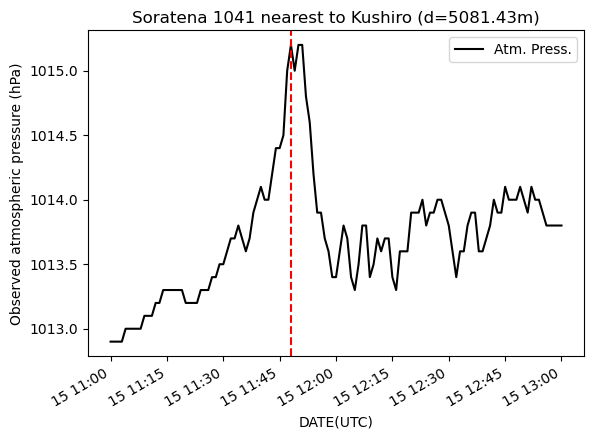

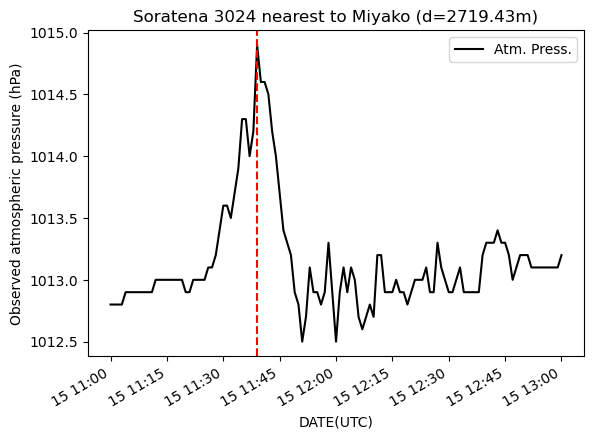

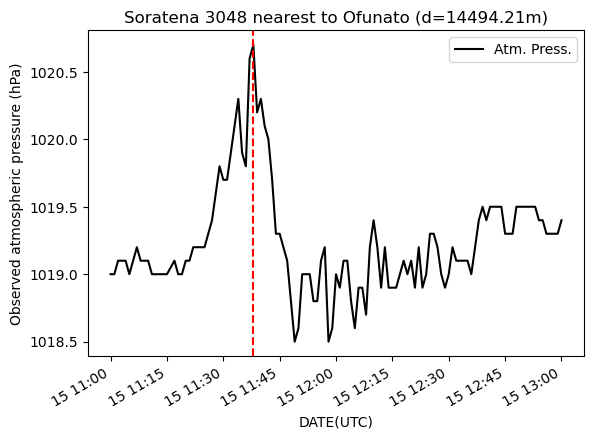

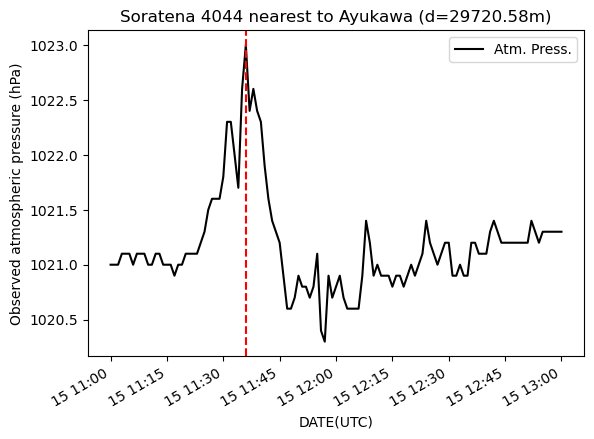

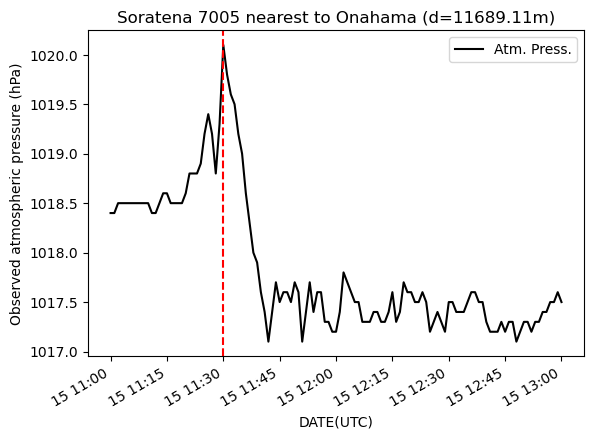

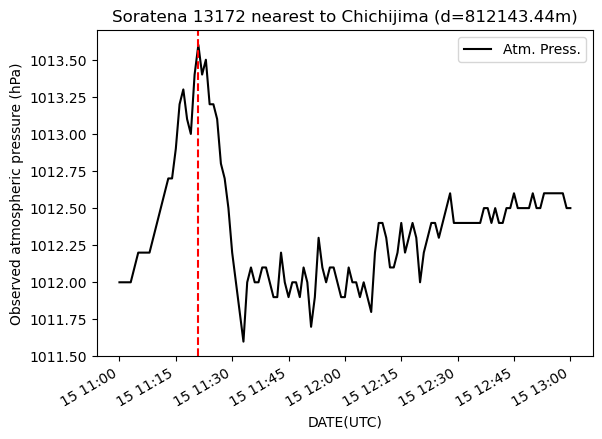

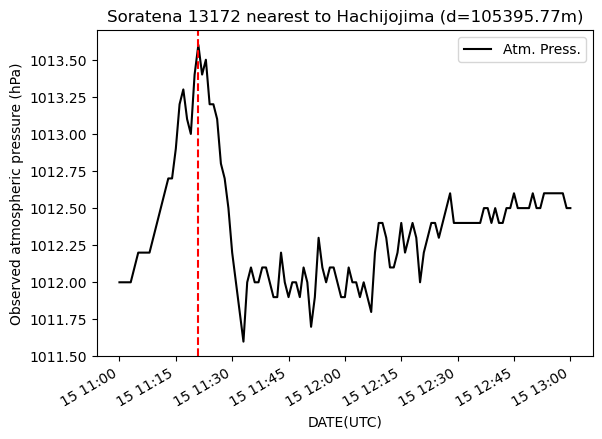

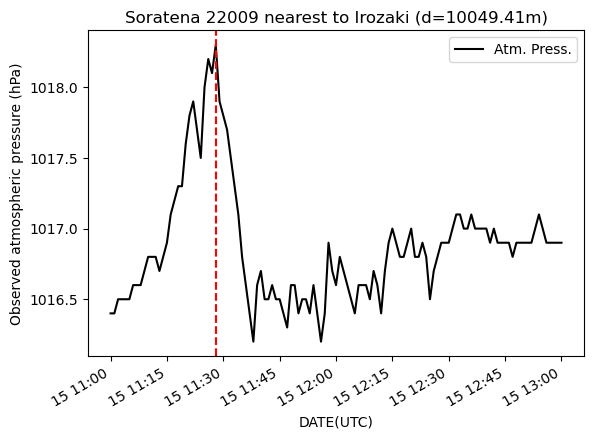

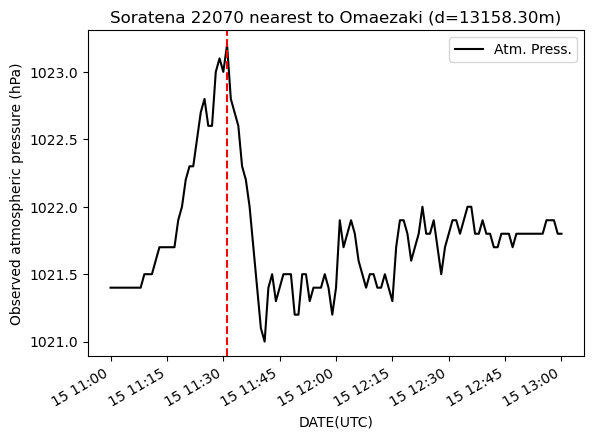

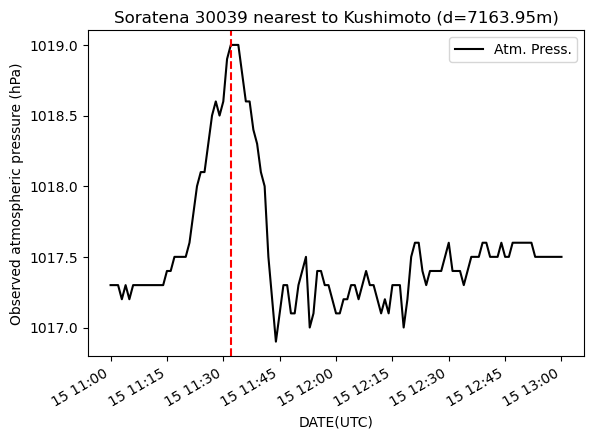

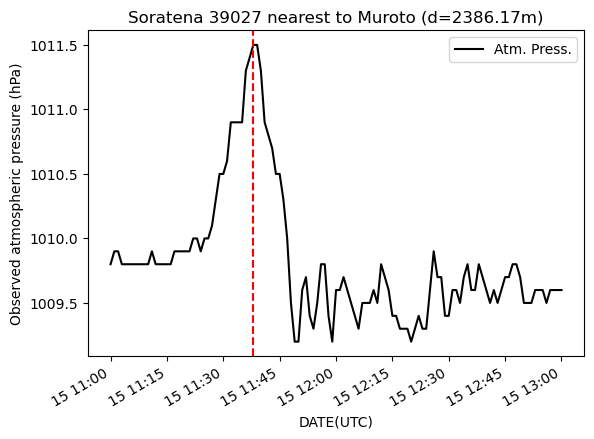

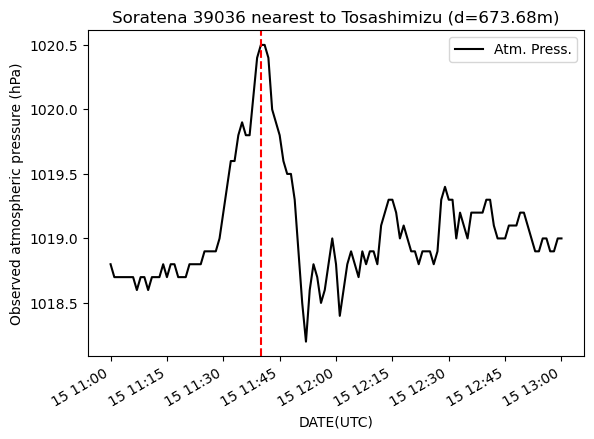

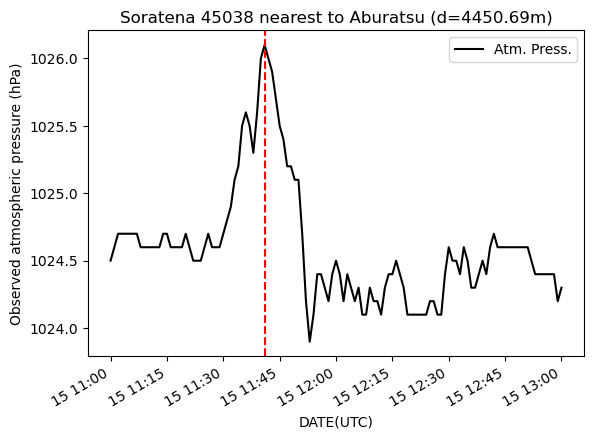

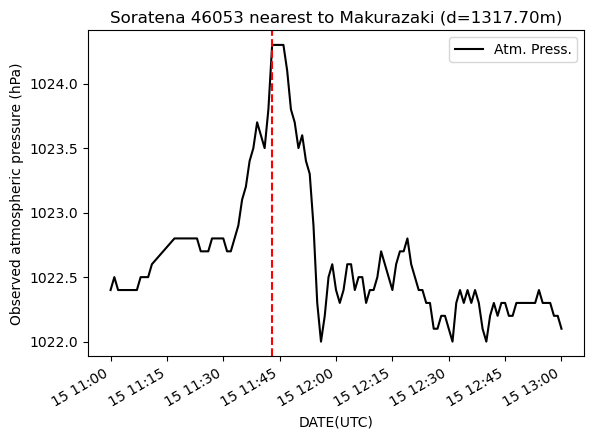

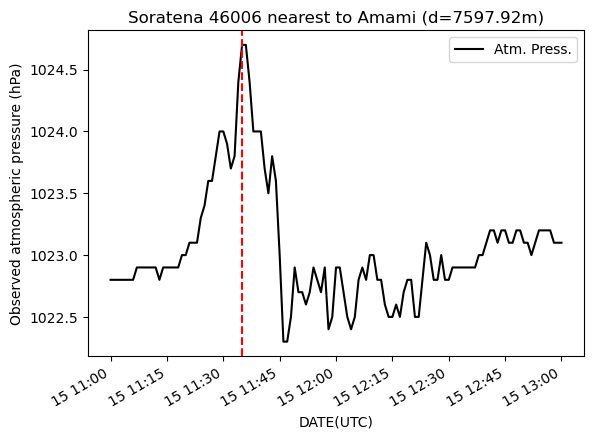

In [106]:
#create a range of dates from the data
# x = pd.date_range(start=df['DATE(UTC)'].min(),end=df['DATE(UTC)'].max(),freq='60s',)
x = pd.date_range(start='2022-01-15 11:00:00',end='2022-01-16 00:00:00',freq='60s',)
#get data and plot until maximum
#create a df with ids,dates,max air pressure
for i, row in apst.iterrows():
    id = row['SoratenaID']
    temp = dfgByID.get_group(id)
    y = temp[temp['DATE(UTC)'].isin(x)]
    max_value = y['ARPRSS'].max()
    pos_max = y['ARPRSS'].idxmax()
    date_max = y['DATE(UTC)'][pos_max]
    ax = y.plot(x='DATE(UTC)',y='ARPRSS',color='k',label='Atm. Press.')
    ax.axvline(date_max,ls='--',color='red',label='max')
    ax.set_ylabel('Observed atmospheric pressure (hPa)')
    ax.set_title(f'Soratena {id} nearest to {row["Station"]} (d={row["dist"]:.2f}m)')
    plt.savefig(f'./figs/{row["Station"]}_{id}.png')